<a href="https://colab.research.google.com/github/Rovidicus/Prediction-of-Product-Sales/blob/main/PriceHills%26SalesClimbs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import modeling tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

In [4]:
# Saving the filepath and assigning dataframe as df
fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)

In [5]:
# Inspecting data
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
df.shape

(8523, 12)

In [7]:
# Checking duplicates
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
# Dropping Item Identifier due to high cardinality
df=df.drop("Item_Identifier", axis=1)

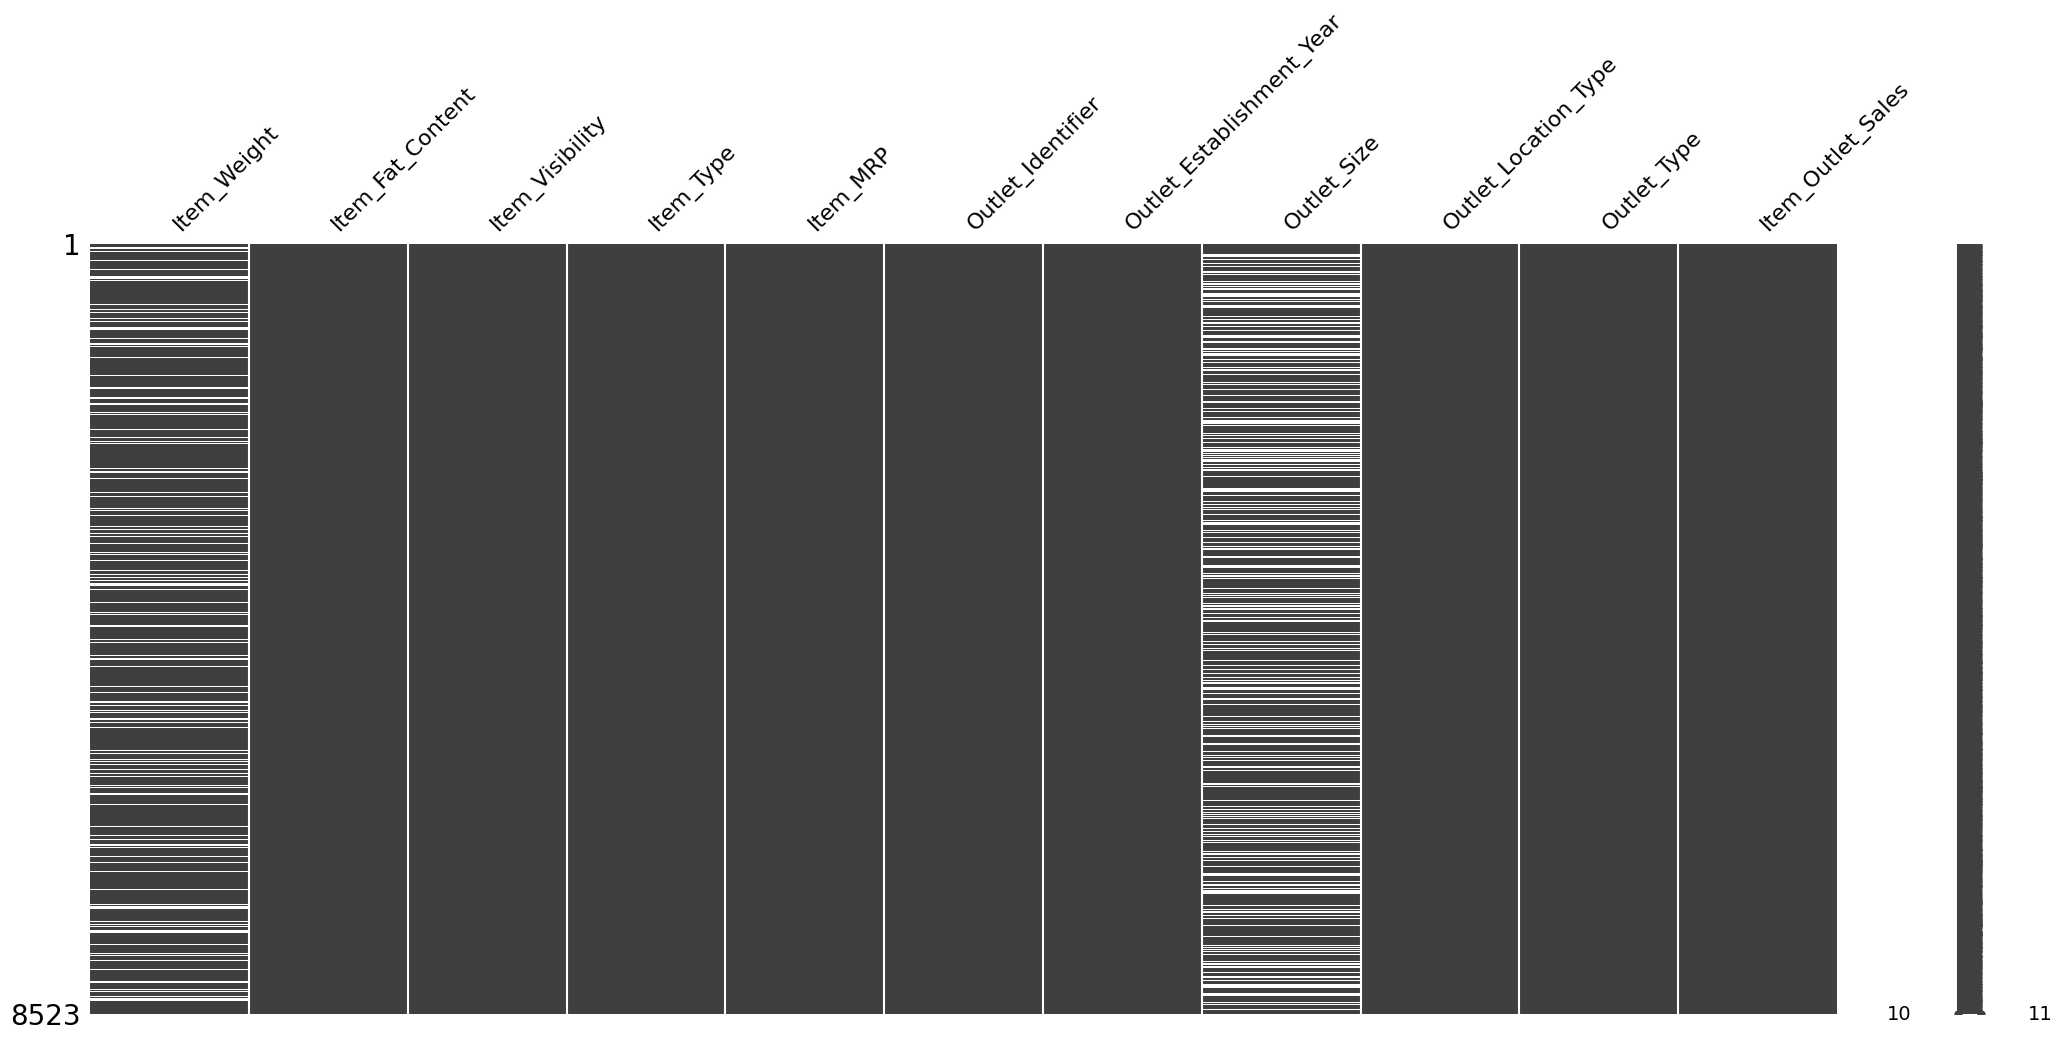

In [10]:
# Visualizing the missing values using the missingno package.
import missingno as msno
msno.matrix(df);

In [11]:
# Find and fix any inconsistent categories of data.
# Saving a list of object columns
obj_cols = df.select_dtypes('object').columns
obj_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [12]:
# looping through the list of string columns
  # printing the value counts for the column and an empty line for readability
for col in obj_cols:
  print(f'The Value Counts for {col}')
  print(df[col].value_counts())
  print('\n')

The Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


The Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


The Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64


The Value Counts for Outlet_Size
Medium    2793
Small     2388
High       932
Nam

In [13]:
# Reassigning entry errors for Item Fat Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [14]:
# Reassign value name 'High' in 'Store Size' column to more appropriate name: 'Large'
df['Outlet_Size'] = df['Outlet_Size'].str.replace('High', 'Large')
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

In [15]:
# Checking that numeric columns are correctly labeled
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [84]:
# Display the min, the max and the average of the numerical columns
df.describe()

,Item_Weight,Item_Visibility(%),Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.00","7,997.00","8,523.00","8,523.00","8,523.00"
mean,12.86,7.05,140.99,"1,997.83","2,181.29"
std,4.64,5.03,62.28,8.37,"1,706.50"
min,4.55,0.36,31.29,"1,985.00",33.29
25%,8.77,3.14,93.83,"1,987.00",834.25
50%,12.60,5.78,143.01,"1,999.00","1,794.33"
75%,16.85,9.81,185.64,"2,004.00","3,101.30"
max,21.35,32.84,266.89,"2,009.00","13,086.96"


In [17]:
df['Item_Visibility'].value_counts()

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64

In [18]:
# There's a large portion of values at 0. Replacing with nulls to be imputed as median in preprocessing
df['Item_Visibility'] = df['Item_Visibility'].replace(df['Item_Visibility'].min(), np.nan)

In [19]:
# Checking that zeroes became nulls
df['Item_Visibility'].isna().sum()

526

In [20]:
# Multiplying item visiblity values to display for percentage
df['Item_Visibility'] = df['Item_Visibility']*100
df['Item_Visibility'].value_counts()

7.697512     3
16.246204    2
7.684109     2
7.356248     2
13.570755    2
            ..
1.395731     1
11.045983    1
12.464554    1
5.414209     1
4.487828     1
Name: Item_Visibility, Length: 7879, dtype: int64

In [21]:
# Renaming visibility to show %
df = df.rename(columns = {'Item_Visibility':'Item_Visibility(%)'})

In [87]:
# Checking Item Weight
df['Item_Weight'].isna().sum()

1463

In [22]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility(%),Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,1.604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,1.927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,1.676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,NaN,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


In [23]:
# The target we are trying to predict
y = df['Item_Outlet_Sales']
# The features we will use to make the prediction
X = df.drop(columns = ['Item_Outlet_Sales'])
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility(%),Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,2.956531,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,NaN,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,15.871573,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,1.462838,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,1.664516,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


# Preparing ordinal pipeline

In [24]:
# Defining list of ordinals
ord_cols = ['Outlet_Size']

In [25]:
# Checking nulls
X_train[ord_cols].isna().sum()

Outlet_Size    1812
dtype: int64

In [26]:
X_train[ord_cols].value_counts()

Outlet_Size
Medium         2103
Small          1788
Large           689
dtype: int64

In [27]:
# Imputing ordinal values with constant as there is too much missing to impute into most frequent
impute_na_ord = SimpleImputer(strategy='constant', fill_value='Missing')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
qual_cond_order = ['Small','Medium','Large','Missing']

In [28]:
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [qual_cond_order]

ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()

In [29]:
# Making an ord_pipe and displaying
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'Large',
                                             'Missing']])),
                ('standardscaler', StandardScaler())])

# Preparing categorical pipeline

In [30]:
# Defining list of categoricals
cat_cols = X_train.select_dtypes("object").columns
cat_cols = cat_cols.drop(ord_cols)
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [31]:
# Instantiating individual preprocessors
impute_na_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [32]:
# Instantiate the pipeline
ohe_pipe = make_pipeline(impute_na_cat, ohe_encoder)
ohe_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Numeric pipeline

In [33]:
# Defining lists of types of features
num_cols = X_train.select_dtypes("number").columns
num_cols

Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [34]:
# The float Item Visibility has numerous null values, imputing with mean
# instantiate preprocessor
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()

In [35]:
# Instantiate and display the pipeline
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

# Creating tuples

In [36]:
# Creating three tuples for Ordinal, Categorical and Numeric pipelines
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Missing', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'Large',
                                              'Missing']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

In [37]:
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

In [38]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

In [39]:
# Instantiate with verbose_feature_names_out=False
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  O...
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [40]:
# Fit on training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  O...
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [41]:
# Transform the training data
X_train_tf = preprocessor.transform(X_train)
# Transform the testing data
X_test_tf = preprocessor.transform(X_test)
# View the processed training data
X_train_tf.head()

,Item_Weight,Item_Visibility(%),Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.817249,-0.847501,1.828109,1.327849,-0.338062,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.556340,0.000000,0.603369,1.327849,-0.338062,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.131512,1.832065,0.244541,0.136187,-0.338062,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.169219,-1.157407,-0.952591,0.732018,-1.193861,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.528819,-1.115563,-0.336460,0.493686,1.373536,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [42]:
# View the processed testing data
X_test_tf.head()

,Item_Weight,Item_Visibility(%),Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,3.310089e-01,-0.915252,-0.998816,-1.293807,0.517737,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2957,-1.179892e+00,0.014990,-1.585194,-0.102145,-1.193861,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,3.784469e-01,-0.603760,-1.595784,0.136187,-0.338062,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1084,4.213344e-16,-0.532101,0.506592,-1.532139,-0.338062,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
856,-6.426567e-01,-1.202483,0.886725,0.732018,-1.193861,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# CRISP-DM Phase 4 - Modeling

## Build a linear regression model to predict sales.

In [43]:
# Provide a label for this data
label = 'Test Data'
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [44]:
from sklearn.linear_model import LinearRegression
# Instantiate model
lin_reg = LinearRegression()
#Fit model
lin_reg.fit(X_train_tf, y_train)

LinearRegression()

In [45]:
 # Test function with default arguments
evaluate_regression(lin_reg, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.271
- MSE = 1,297,801.640
- RMSE = 1,139.211
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 803.759
- MSE = 1,193,986.019
- RMSE = 1,092.697
- R^2 = 0.567


In [46]:
# Test function by saving results as a datframe
results_df = evaluate_regression(lin_reg, X_train_tf, y_train, X_test_tf, y_test,
                              verbose=False, output_frame=True)
results_df

,MAE,MSE,RMSE,R^2
Training Data,847.271,1297801.640,1139.211,0.561
Test Data,803.759,1193986.019,1092.697,0.567


### To what extent is this model overfit/underfit?

- With only a .56 r^2 score on training and testing data and mean values in the hundreds, thousands and millions, the model is very underfit for the task of predicting Item Outlet Sales.

## Build a Random Forest model to predict sales.

In [47]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(preprocessor, rf)

In [48]:
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 stra...
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [49]:
# Use custom function to evaluate default model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.248
- MSE = 184,727.773
- RMSE = 429.800
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 766.893
- MSE = 1,220,670.843
- RMSE = 1,104.840
- R^2 = 0.558


In [ ]:
# Getting parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('ordinalencoder',
                                                     Ordi...
                                 

In [ ]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[1,2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None,1],
          'randomforestregressor__oob_score':[True,False],
          }

In [ ]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None, 1],
                         'randomforestregressor__min_samples_leaf': [1, 2, 3,
                                                                     4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [ ]:
# Obtain best parameters
gridsearch.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__oob_score': True}

In [ ]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 661.548
- MSE = 889,858.636
- RMSE = 943.323
- R^2 = 0.699

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 733.109
- MSE = 1,113,840.201
- RMSE = 1,055.386
- R^2 = 0.596


## Did the performance improve?

- Barely in the test data, and much worse in training. That means the forest model isn't overfit at least but much tweaking remains to be done.

## which model to recommend?

- Both models need improvement. However the linear regression model, while consistent, has high bias. With the random forest model there's less overfitting and a slight improvement in r^2 thus that would be recommended.

- With an r^2 of 0.591 the random forest model is accounting for about 59% of the error rate but cannot yet predict 41%. Adjustments need to be made for accuracy.
- The MAE (mean absolute error) for testing is 738, which for item outlet sales a significant variance that needs to be narrowed. This is showing that the model can't yet be relied on to predict future sales within 738 of what its value should be.
- The random forest model training data at least isn't overfit at r2 of 0.722 for training and testing r2 of 0.591. These metrics could be improved possibly with eliminating some irrelevant features and refitting.

In [50]:
# fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_tf, y_train)
evaluate_regression(lin_reg, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.271
- MSE = 1,297,801.640
- RMSE = 1,139.211
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 803.759
- MSE = 1,193,986.019
- RMSE = 1,092.697
- R^2 = 0.567


In [52]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                       -8.104550e+00
Item_Visibility(%)                -1.424556e+01
Item_MRP                           9.845535e+02
Outlet_Establishment_Year         -3.095392e+14
Outlet_Size                       -7.868835e+13
Item_Fat_Content_Low Fat          -2.774583e+14
Item_Fat_Content_Regular          -2.774583e+14
Item_Type_Baking Goods             9.714755e+12
Item_Type_Breads                   9.714755e+12
Item_Type_Breakfast                9.714755e+12
Item_Type_Canned                   9.714755e+12
Item_Type_Dairy                    9.714755e+12
Item_Type_Frozen Foods             9.714755e+12
Item_Type_Fruits and Vegetables    9.714755e+12
Item_Type_Hard Drinks              9.714755e+12
Item_Type_Health and Hygiene       9.714755e+12
Item_Type_Household                9.714755e+12
Item_Type_Meat                     9.714755e+12
Item_Type_Others                   9.714755e+12
Item_Type_Seafood                  9.714755e+12
Item_Type_Snack Foods              9.714

In [53]:
# Values are absurdly large. Adjusting by splitting data again
# Also am removing several immutable features relating to the outlets but leaving Outlet_Size since stores can be remodeled
# Make x and y variables
y = df['Item_Outlet_Sales'].copy()
X = df.drop(columns=['Item_Outlet_Sales','Outlet_Identifier','Outlet_Location_Type','Outlet_Establishment_Year','Outlet_Type'])
# train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility(%),Item_Type,Item_MRP,Outlet_Size
4776,16.350,Low Fat,2.956531,Household,256.4646,Medium
7510,15.250,Regular,NaN,Snack Foods,179.7660,Medium
5828,12.350,Regular,15.871573,Meat,157.2946,Medium
5327,7.975,Low Fat,1.462838,Baking Goods,82.3250,Small
4810,19.350,Low Fat,1.664516,Frozen Foods,120.9098,NaN


In [54]:
# Defining list of ordinals
ord_cols = ['Outlet_Size']
# Imputing ordinal values with constant as there is too much missing to impute into most frequent
impute_na_ord = SimpleImputer(strategy='constant', fill_value='MISSING')
# Specifying order of categories for our  Ordinal Qual/Cond Columms
qual_cond_order = ['Small','Medium','Large','MISSING']
# Making the order list for OrdinalEncoder
ordinal_category_orders = [qual_cond_order]
# Encoding ordinal column
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
# Making ordinal tuple
ord_tuple = ('ordinal', ord_pipe, ord_cols)

# Reestablishing categorical columns, this time encoding if_binary for one hot encoder
ohe_cols = X_train.select_dtypes('object').drop(columns = ord_cols).columns
# instantiate preprocessors
impute_constant = SimpleImputer(strategy='constant', fill_value= 'MISSING')
# add argument drop = 'if_binary' so Item Fat Content is a single column
ohe_encoder = OneHotEncoder(drop = 'if_binary', sparse=False)
# make pipeline for categorical data
ohe_pipe = make_pipeline(impute_constant, ohe_encoder)
# make tuple for column transformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

# make list of numeric columns
num_cols = X_train.select_dtypes('number').columns
# Outlet year established is an integer column so median will be used, plus prevents outliers overly affecting results
impute_mean =(SimpleImputer(strategy='median'))
# make pipeline for numerical data
num_pipe = make_pipeline(SimpleImputer(strategy='median'))
# make tuple for column transfomer
num_tuple = ('numeric', num_pipe, num_cols)

# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large',
                                                                              'Missing']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [55]:
# fitting a linear regression model
lin_reg = LinearRegression()
lrpipe = make_pipeline(preprocessor, lin_reg)
lrpipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEnco...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [56]:
# Fitting linear regression pipe to data again
lrpipe.fit(X_train, y_train)
evaluate_regression(lrpipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,031.205
- MSE = 1,940,595.387
- RMSE = 1,393.053
- R^2 = 0.344

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,000.721
- MSE = 1,831,133.141
- RMSE = 1,353.194
- R^2 = 0.336


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Linear regression is clearly not the ideal model with most of the error rate unaccounted for and the average prediction seeming to be a thousand dollars off.

In [57]:
# Making features list
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP', 'Outlet_Size',
       'Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods'], dtype=object)

In [58]:
# Saving new coeffs
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                         -3.307642
Item_Visibility(%)                 -48.184858
Item_MRP                            15.541863
Outlet_Size                        -90.382690
Item_Fat_Content_Regular            58.489040
Item_Type_Baking Goods             -12.677442
Item_Type_Breads                   -37.588479
Item_Type_Breakfast                 10.394312
Item_Type_Canned                    41.997033
Item_Type_Dairy                   -135.394166
Item_Type_Frozen Foods             -21.904683
Item_Type_Fruits and Vegetables     64.061191
Item_Type_Hard Drinks               19.371789
Item_Type_Health and Hygiene       -39.831712
Item_Type_Household                -52.306481
Item_Type_Meat                     -54.981630
Item_Type_Others                  -206.126356
Item_Type_Seafood                  344.107098
Item_Type_Snack Foods              -31.188116
Item_Type_Soft Drinks              -54.926865
Item_Type_Starchy Foods            166.994508
intercept                         

In [59]:
# Better. The strong negative effect of Item Visibility was due before to not multiplying by 100 to display proper percentage
# Plotting coefficients with custom function in next two cells.

In [60]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
def plot_coeffs(coeffs, top_n=None,  figsize=(6,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')

    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"

    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    ## return ax in case want to continue to update/modify figure
    return ax

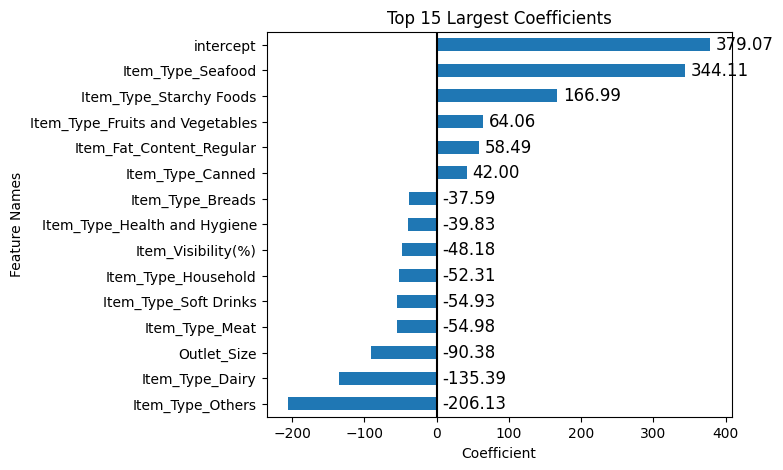

In [61]:
ax = plot_coeffs(coeffs, top_n = 15, intercept = True)
# Looping in coefficient values
for bar in ax.patches:
    ## calculate center of bar
    bar_ax = bar.get_y() + bar.get_height() / 2
    ## get the value to annotate
    val = bar.get_width()

    if val < 0:
        val_pos = 0
    else:
        val_pos = val

    # ha and va stand for the horizontal and vertical alignment
    ax.annotate(f"{val:.2f}", (val_pos,bar_ax),
                ha='left', va='center',size=12,
                xytext=(4,0), textcoords='offset points')

1. An intercept at 379.07 shows the baseline prediction of item outlet sales at $379.07.

2. The highest predictor was seafood at a strong positive of $344.11, making seafood the best seller of all item types.

3. Next strongest was a negative value for items labeled "others" at -$206.13. This may be due to said items having niche or limited consumer interest. Such items could be very seasonal also, so they don't sell much for most of the year.

4. The next strongest was starchy foods at $166.99, consistently good sales.

# Tree-Based Model

In [65]:
# Making random forest with pipeline
rf = RandomForestRegressor(random_state=42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Item_Weight', 'Item_Visibility(%)', 'Item_MRP'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEnco...
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [64]:
# Using custom functions for decision tree analysis
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [66]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 342.259
- MSE = 230,521.071
- RMSE = 480.126
- R^2 = 0.922

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 886.269
- MSE = 1,516,724.799
- RMSE = 1,231.554
- R^2 = 0.450


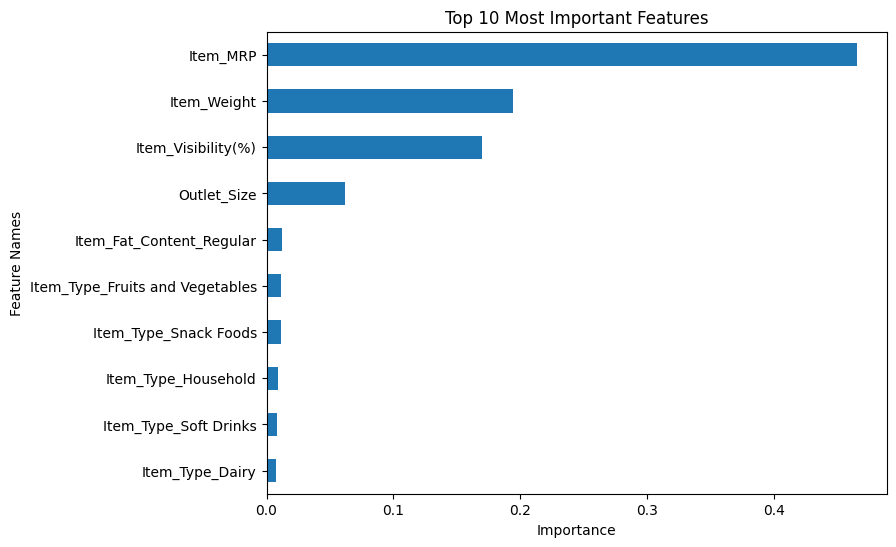

In [70]:
rf_pipe.fit(X_train, y_train)
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)
# Saving the feature importances
importances = get_importances(rf)
plot_importance(importances, top_n=10);

### With Random Forest the top five coefficients are Item Max Retail Price,
### Item Weight, Item Visibility, Outlet Size and Regular Item Fat Content.
### These are quite different results from the linear regression model but
### random forest has more accurate metrics and results are consistent with
### previous models that Max Retail Price is a strong indicator of good sales.

In [88]:
# Making a base decision tree
example_tree =  rf.estimators_[0]
example_tree

DecisionTreeRegressor(max_features=1.0, random_state=1608637542)

In [89]:
evaluate_regression(example_tree, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.000
- MSE = 0.000
- RMSE = 0.000
- R^2 = 1.000

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,172.292
- MSE = 2,742,316.717
- RMSE = 1,655.994
- R^2 = 0.006


### With a decision tree of such poor results, the random forest remains the
### best model.